# **Análisis Funnel de Ventas: InnerCodes para la categoría de Locating Pins**
## **Path to purchase en plataforma de e-commerce: MISUMI MÉXICO**

**Funnel de ventas para Locating Pins**

**_Data Science PIC:_**

Eduardo A. Leonardo - AI Innovation Engineer

**_Project Management PIC:_**

José Santamaría - Customer Engineer

**Rango de los datos: FY2024 y FY2025 hsata el mes de Julio**


# **Introducción**

El presente trabajo desarrolla un **proyecto de análisis de datos aplicado a la categoría *Locating Pins*** dentro del catálogo de **MISUMI México**.  
Su objetivo principal es comprender el comportamiento del cliente a lo largo del **proceso de conversión o *path to purchase***, desde la generación del número de parte hasta la venta final.

Para ello se integran y procesan diferentes fuentes de información que representan las etapas clave del embudo comercial:

- Generación de números de parte en el configurador del catálogo.  
- Descargas de modelos CAD 2D/3D por parte de los usuarios.  
- Solicitudes de cotización (*Quotations*).  
- Órdenes de venta confirmadas (*Sales Orders*).

A partir de estos datos, se implementan técnicas de **data wrangling**, **web scraping** y **feature engineering** para consolidar un conjunto de datos limpio, enriquecido y listo para análisis.  
Posteriormente, se desarrollan visualizaciones y modelos que permiten **evaluar la eficiencia del funnel**, identificar los productos con mayor impacto y medir la conversión efectiva entre las distintas fases.

El enfoque analítico de este notebook busca **apoyar la toma de decisiones estratégicas** sobre la familia *Locating Pins*, ofreciendo información cuantitativa sobre tendencias de comportamiento, desempeño comercial y oportunidades de mejora en la oferta de productos.


## **Bancos de Datos y Preprocesamiento: *Locating Pins***

En esta etapa se analizaron **cuatro archivos CSV** que contienen información clave sobre las distintas fases del *path to purchase* del cliente.  
Cada archivo representa una etapa específica del proceso de interacción con el catálogo de MISUMI:

1. **Generación de números de parte:**  
   Contiene los códigos creados por los usuarios al configurar componentes personalizados.

2. **Generación de modelos y descarga de CADs:**  
   Registra los eventos de descarga de modelos 3D o 2D, reflejando interés técnico y validación de diseño.

3. **Números de parte cotizados:**  
   Incluye los productos que fueron solicitados para cotización, evidenciando una intención de compra avanzada.

4. **Números de parte vendidos:**  
   Agrupa los componentes que finalmente fueron adquiridos, completando el ciclo de compra.

El análisis conjunto de estos archivos permite **visualizar el embudo de conversión del cliente** y comprender de forma integral su comportamiento a lo largo del proceso de adquisición de *Locating Pins*.



In [1]:
!pip -q install requests beautifulsoup4 lxml tqdm

In [2]:
import re, time, json, os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

Data Frame Generación de números de parte "df_pngen_2425"

In [3]:
df1 = pd.read_csv("/content/allcadfy24.csv", encoding="utf-16", sep="\t")
df2 = pd.read_csv("/content/cadall.csv", encoding="utf-16", sep="\t")
df_cad_2425 = pd.concat([df1, df2], ignore_index=True)

In [4]:
df_pngen_2425 = pd.read_excel("/content/pngen_2425.xlsx")

Data Frame: Generación y descarga de CADs para periodos FY24 y FY25 "df_cad_2425"

Concatenación de datos: Generación y descarga de CADS para periodos FY24 y FY25

In [5]:
df1 = pd.read_csv("/content/allcadfy24.csv", encoding="utf-16", sep="\t")
df2 = pd.read_csv("/content/cadall.csv", encoding="utf-16", sep="\t")
df_cad_2425 = pd.concat([df1, df2], ignore_index=True)

Data Frame: Números de parte cotizados "df_qt_2425"

In [6]:
df_qt_2425 = pd.read_csv("/content/QT_MMEX_LocatingPins.csv")

In [7]:
df_qt_2425 = df_qt_2425[["REG_USR", "PRODUCT_CD", "BRAND_CD", "INNER_CD", "QT_QTY", "PRODUCT_NAME" ]]

In [8]:
df_qt_2425 = df_qt_2425[df_qt_2425["PRODUCT_NAME"].isin(["LOCATING PIN", "locating pin"])]

In [9]:
df_qt_2425 = df_qt_2425.rename(columns={"REG_USR": "CUSTOMER_CODE", "PRODUCT_CD": "PRODUCT_CODE",})

Data Frame: Números de parte vendidos "df_so_2425"

In [10]:
df_so_2425 = pd.read_csv("/content/SO_MMEX_LocatingPins.csv")
df_so_2425 = df_so_2425[["REG_USR", "PRODUCT_CD", "BRAND_CD", "INNER_CD", "SO_QTY", "PRODUCT_NAME" ]]
df_so_2425 = df_so_2425[df_so_2425["PRODUCT_NAME"].isin(["LOCATING PIN", "locating pin"])]
df_so_2425 = df_so_2425.rename(columns={"REG_USR": "CUSTOMER_CODE", "PRODUCT_CD": "PRODUCT_CODE",})

Data Frame: Relación entre Inner Code y Series Code para Locating Pins
"df_cds_relation"

In [11]:
df_cds_relation = pd.read_excel("/content/inner_series_relation.xlsx")

In [12]:
df_cds_relation = df_cds_relation.rename(columns={"SERIES CODE": "SERIES_CODE",})

## **Feature Engineering: *Locating Pins***

**Data Wrangling y enriquecimiento con datos disponibles**

### Relación entre *Inner Code* y *Series Code* para el banco de *Quotations* y *Sales Orders*

Se realiza una **estandarización de los nombres** y de sus llaves de unión.  
Todas las claves son convertidas a texto y se eliminan espacios en blanco para evitar errores en los cruces entre *Inner Code* y *Series Code* dentro del *data frame* de *Quotations*.

Posteriormente, se ejecuta un **left join** manteniendo todas las filas del *data frame* `df_qt_2425`, lo que garantiza que no se pierda información del banco de cotizaciones durante la unión con los datos de *Sales Orders*.

Este proceso forma parte del *Feature Engineering*, ya que permite **enriquecer las observaciones de cotizaciones con información de ventas reales**, facilitando el análisis de conversión y priorización de productos dentro de la categoría *Locating Pins*.



##### Quotation

In [13]:
df_qt_2425.columns  = (df_qt_2425.columns .str.strip().str.replace(r"\s+","_",regex=True).str.upper())
df_cds_relation.columns = (df_cds_relation.columns.str.strip().str.replace(r"\s+","_",regex=True).str.upper())

df_qt_2425["INNER_CD"] = df_qt_2425["INNER_CD"].astype(str).str.strip()

rel_key = "INNER_CODE" if "INNER_CODE" in df_cds_relation.columns else "INNER_CD"
df_cds_relation[rel_key] = df_cds_relation[rel_key].astype(str).str.strip()

df_cds_relation["SERIES_CODE"] = df_cds_relation["SERIES_CODE"].astype(str)

df_qt_2425 = df_qt_2425.merge(
    df_cds_relation[[rel_key, "SERIES_CODE"]].rename(columns={rel_key: "INNER_CD", "SERIES_CODE": "SERIES_CD"}),
    on="INNER_CD", how="left"
)

df_qt_2425["SERIES_CD"] = df_qt_2425["SERIES_CD"].fillna("NO_MATCH")


In [14]:
no_match_count_qt = (df_qt_2425["SERIES_CD"] == "NO_MATCH").sum()

print("Cantidad de NO_MATCH en SERIES_CD para Quotations:", no_match_count_qt)


Cantidad de NO_MATCH en SERIES_CD para Quotations: 2647


In [15]:
print("Porcentaje de valores faltantes del conjunto total de datos: ")
print((no_match_count_qt/df_qt_2425.shape[0])*100, "%")

Porcentaje de valores faltantes del conjunto total de datos: 
67.66359918200409 %


##### Sales Orders

In [16]:
df_so_2425.columns  = (df_so_2425.columns .str.strip().str.replace(r"\s+","_",regex=True).str.upper())
df_cds_relation.columns = (df_cds_relation.columns.str.strip().str.replace(r"\s+","_",regex=True).str.upper())

df_so_2425["INNER_CD"] = df_so_2425["INNER_CD"].astype(str).str.strip()

rel_key = "INNER_CODE" if "INNER_CODE" in df_cds_relation.columns else "INNER_CD"
df_cds_relation[rel_key] = df_cds_relation[rel_key].astype(str).str.strip()

df_cds_relation["SERIES_CODE"] = df_cds_relation["SERIES_CODE"].astype(str)

df_so_2425 = df_so_2425.merge(
    df_cds_relation[[rel_key, "SERIES_CODE"]].rename(columns={rel_key: "INNER_CD", "SERIES_CODE": "SERIES_CD"}),
    on="INNER_CD", how="left"
)

df_so_2425["SERIES_CD"] = df_so_2425["SERIES_CD"].fillna("NO_MATCH")

In [17]:
no_match_count_so = (df_so_2425["SERIES_CD"] == "NO_MATCH").sum()

print("Cantidad de NO_MATCH en SERIES_CD para Quotations:", no_match_count_so)

Cantidad de NO_MATCH en SERIES_CD para Quotations: 1175


In [18]:
print("Porcentaje de valores faltantes del conjunto total de datos: ")
print((no_match_count_so/df_so_2425.shape[0])*100, "%")

Porcentaje de valores faltantes del conjunto total de datos: 
61.45397489539749 %


El 68.35% de los datos correspondientes al Series Code de los Part Numbers cotizados presenta un estado de NO_MATCH, así mismo existe un 61.45% de datos faltantes para los vendidos. Esto debido a que las relaciones no se encuentran en nuestro banco de datos "df_cds_relation".

Para evitar omitir datos que pueden ser útiles para el análisis se realizará un scrapping web sobre los 2647 faltantes **Haciendo un HTTP request a MISUMI MX** y **Extrayendo el InnerCode para almacenarlo en el dataframe**

Este proceso se realizará tanto para las Quotations, como para las Sales Order.

##### Visualización de los Data Frames

In [19]:
df_qt_2425.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,BRAND_CD,INNER_CD,QT_QTY,PRODUCT_NAME,SERIES_CD
0,QU0516,CKFQSAHM5-P4.2-L10-B8,MSM1,30085861604,1,LOCATING PIN,110302661250
1,QU0516,CKFTAHH6-P7.98-L9-B4-E2-A15,MSM1,30085181794,2,LOCATING PIN,NO_MATCH
2,QU0486,CKFQSAHM5-P4.2-L10-B8,MSM1,30085861604,2,LOCATING PIN,110302661250
3,WOS,CKFAPH6-P8-L6-B6-E3-A30,MSM1,30085180594,8,LOCATING PIN,110302657140
4,WOS,CKFDPH8-P10-L6-B6-E3-A30,MSM1,30085181265,8,LOCATING PIN,110302657140
5,QU0514,CKFAPH6-P8-L6-B10-E3-A30,MSM1,30085180594,1,LOCATING PIN,110302657140
6,QU0514,CKFDPH8-P10-L6-B10-E3-A30,MSM1,30085181265,1,LOCATING PIN,110302657140
7,QU0506,TRATDB6-P6.6-B15-A30,MSM1,30242930007,1,LOCATING PIN,NO_MATCH
8,QU0469,TRATAB6-P6.7-B15-A30,MSM1,30242920007,1,LOCATING PIN,NO_MATCH
9,QU0517,TELNSAB12-P14.0-B10-L5-A60,MSM1,30243820010,2,LOCATING PIN,NO_MATCH


In [20]:
df_so_2425.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,BRAND_CD,INNER_CD,SO_QTY,PRODUCT_NAME,SERIES_CD
0,WOS,SPSST3-L8-P1.5-B11-H5-T2,MSM1,30259350003,5,LOCATING PIN,NO_MATCH
1,QU0514,JPNGB6-P8-B10-G5,MSM1,30086010013,1,LOCATING PIN,110302194710
2,WOS,TELNNA10-P16-B8-L12-MK-KD,MSM1,30006320001,2,LOCATING PIN,NO_MATCH
3,WOS,TELNND10-P12-B12-L12,MSM1,30006480001,2,LOCATING PIN,NO_MATCH
4,QU0550,SLPT5-15,MSM1,30085010001,8,LOCATING PIN,110302664050
5,QU0514,GJPNGB3-P7-B10-G6,MSM1,30086020010,1,LOCATING PIN,NO_MATCH
6,QU0516,KFTDHH8-P12-L12-B10-E4-A15,MSM1,30085181935,8,LOCATING PIN,NO_MATCH
7,QU0516,KFTAHH8-P12-L12-B10-E4-A15,MSM1,30085181515,6,LOCATING PIN,110302657320
8,WOS,KFSTDGP5-P3.3-L8-B5-E1-A30,MSM1,30085193839,2,LOCATING PIN,110302660820
9,WOS,KFSTAGP5-P3.3-L8-B5-E1-A30,MSM1,30085193819,2,LOCATING PIN,110302660820


## **WEB SCRAPPING Y PREPROCESAMIENTO DE DATOS**

**Obtención de datos por medio de webscrapping, estandarización e integración**

Este bloque de código realiza un **enriquecimiento automático del DataFrame** mediante la búsqueda y actualización de códigos faltantes en la base de datos.  
El proceso identifica los registros con `SERIES_CD = "NO_MATCH"` y utiliza un **web scraping paralelo** sobre el sitio web de **MISUMI México** para buscar cada `PRODUCT_CODE`.  

Cuando se encuentra una coincidencia, el script extrae el `SERIES_CODE` directamente desde la URL del producto y lo utiliza para **actualizar el DataFrame original**.  
De esta forma, se reemplazan valores faltantes por códigos válidos y se obtiene un **dataset más completo y confiable** para el análisis posterior.

### Pipelines implementados:
- **Quotation Pipeline:** proceso de enriquecimiento para el banco de cotizaciones.  
- **Sales Order Pipeline:** proceso equivalente aplicado al banco de órdenes de venta.





###### Quotation Pipeline

In [21]:
UA = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"
session = requests.Session()
session.headers.update({"User-Agent": UA, "Accept-Language": "es-MX,es;q=0.9,en;q=0.8"})
retry = Retry(total=3, backoff_factor=0.5, status_forcelist=[429, 500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retry, pool_connections=100, pool_maxsize=100)
session.mount("http://", adapter)
session.mount("https://", adapter)

detail_rx = re.compile(r"/detail/(\d+)/")

def extract_series_from_url(url: str):
    m = detail_rx.search(url or "")
    return m.group(1) if m else None

def get_series_code_from_misumi(pn: str, timeout=12) -> str | None:
    """
    1) Abre la búsqueda (deja seguir redirecciones).
    2) Si la URL final ya es /vona2/detail/####/ -> extrae.
    3) Si no, parsea el HTML y toma la primera liga a /vona2/detail/.
    """
    kw = quote(str(pn))
    search_urls = [
        f"https://mx.misumi-ec.com/es/search/?Keyword={kw}",
        f"https://mx.misumi-ec.com/es/vona2/result/?Keyword={kw}",
    ]

    for url in search_urls:
        try:
            r = session.get(url, allow_redirects=True, timeout=timeout)
        except Exception:
            continue

        sc = extract_series_from_url(r.url)
        if sc:
            return sc

        try:
            soup = BeautifulSoup(r.text, "lxml")
            link = soup.find("link", rel="canonical")
            if link and link.get("href"):
                sc = extract_series_from_url(link["href"])
                if sc:
                    return sc
            a = soup.select_one('a[href*="/vona2/detail/"]')
            if a and a.get("href"):
                sc = extract_series_from_url(a["href"])
                if sc:
                    return sc
        except Exception:
            pass

    return None

mask = (df_qt_2425["SERIES_CD"] == "NO_MATCH")
targets = df_qt_2425.loc[mask, "PRODUCT_CODE"].astype(str).str.strip()

cache = {}

def worker(pn):
    if pn in cache:
        return pn, cache[pn]
    sc = get_series_code_from_misumi(pn)
    cache[pn] = sc
    return pn, sc

unique_pns = targets.unique()
found = {}

with ThreadPoolExecutor(max_workers=12) as ex:
    futures = {ex.submit(worker, pn): pn for pn in unique_pns}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Buscando series en MISUMI"):
        pn, sc = fut.result()
        if sc:
            found[pn] = sc

df_qt_2425.loc[mask, "SERIES_CD"] = df_qt_2425.loc[mask, "PRODUCT_CODE"].map(found).fillna("NO_MATCH")

total_no_match = (df_qt_2425["SERIES_CD"] == "NO_MATCH").sum()
print(f"Actualizados: {len(found)}  |  NO_MATCH restantes: {total_no_match}  |  Total filas: {len(df_qt_2425)}")



Buscando series en MISUMI:   0%|          | 0/1350 [00:00<?, ?it/s]

Actualizados: 1256  |  NO_MATCH restantes: 254  |  Total filas: 3912


In [22]:
no_match_rows_qt = df_qt_2425[df_qt_2425["SERIES_CD"] == "NO_MATCH"]

print("Total de NO_MATCH:", len(no_match_rows_qt))

Total de NO_MATCH: 254


Observamos un faltante de 256 líneas de inner codes. Aplicamos un head de los 10 primeros elementos para verificar que son Part Numbers no disponibles en el catálogo de MISUMI MX, por lo que no tienen relevancia en nuestro análisis.

Este suceso puede ser explicado por una actualización del listado de componentes disponibles por parte del departamentento de BU, el verificar esta información queda fuera del propósito de nuestro análisis.

In [23]:
no_match_rows_qt.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,BRAND_CD,INNER_CD,QT_QTY,PRODUCT_NAME,SERIES_CD
11,QU0506,PSJAP-SK-D4-P6-B5-L8-E2-A30,MSM1,76715220001,2,LOCATING PIN,NO_MATCH
12,QU0514,PBAB-SKB-D38-L15-P28-H48-T5-R4,MSM1,76760320101,1,LOCATING PIN,NO_MATCH
23,QU0482,AQSA6-P5.95-L10-B10,MSM1,30277510004,1,LOCATING PIN,NO_MATCH
51,WOS,SCPA-SU-D10-L54-P5-B4-E2-M4-SC10-W8-S8,MSM1,76770160001,2,LOCATING PIN,NO_MATCH
74,WOS,ADSHC9-P4.00-L5-B2.0-CN,MSM1,30277650018,1,LOCATING PIN,NO_MATCH
75,WOS,ADSHC9-P4.00-L5-B2.3-CN,MSM1,30277650018,1,LOCATING PIN,NO_MATCH
76,WOS,ADSHC9-P4.00-L5-B2.6-CN,MSM1,30277650018,1,LOCATING PIN,NO_MATCH
93,QU0545,PSKCH-SKR-D8-P7.98-B4.5-L13-E2-A15-M5,MSM1,76716620601,2,LOCATING PIN,NO_MATCH
98,QU0545,AFPBGA6-P10.00-L9-B5.0-E10.0-LAC,MSM1,30277080005,1,LOCATING PIN,NO_MATCH
103,WOS,PSKCH-SKR-D8-P7.98-B13-L13-E5-A15-M5,MSM1,76716620601,4,LOCATING PIN,NO_MATCH


Para facilitar la gestión de los datos, una vez ejecutado el snippet del web scrapping, se renombra y descarga el archivo CSV con el remplazo de los "NO_MATCH" por el series code adecuado.

A los elementos que aún mantienen el status "NO_MATCH" se les aplica un drop para eliminarlos.

In [24]:
df_qt_2425 = df_qt_2425.drop(df_qt_2425[df_qt_2425["SERIES_CD"] == "NO_MATCH"].index)

In [25]:
df_qt_2425.to_csv("df_qt_2425t.csv", index=False, encoding="utf-8")

###### Sales Order Pipeline

In [26]:
UA = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"
session = requests.Session()
session.headers.update({"User-Agent": UA, "Accept-Language": "es-MX,es;q=0.9,en;q=0.8"})
retry = Retry(total=3, backoff_factor=0.5, status_forcelist=[429, 500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retry, pool_connections=100, pool_maxsize=100)
session.mount("http://", adapter)
session.mount("https://", adapter)

detail_rx = re.compile(r"/detail/(\d+)/")

def extract_series_from_url(url: str):
    m = detail_rx.search(url or "")
    return m.group(1) if m else None

def get_series_code_from_misumi(pn: str, timeout=12) -> str | None:
    """
    1) Abre la búsqueda (deja seguir redirecciones).
    2) Si la URL final ya es /vona2/detail/####/ -> extrae.
    3) Si no, parsea el HTML y toma la primera liga a /vona2/detail/.
    """
    kw = quote(str(pn))
    search_urls = [
        f"https://mx.misumi-ec.com/es/search/?Keyword={kw}",
        f"https://mx.misumi-ec.com/es/vona2/result/?Keyword={kw}",
    ]

    for url in search_urls:
        try:
            r = session.get(url, allow_redirects=True, timeout=timeout)
        except Exception:
            continue

        sc = extract_series_from_url(r.url)
        if sc:
            return sc

        try:
            soup = BeautifulSoup(r.text, "lxml")
            link = soup.find("link", rel="canonical")
            if link and link.get("href"):
                sc = extract_series_from_url(link["href"])
                if sc:
                    return sc
            a = soup.select_one('a[href*="/vona2/detail/"]')
            if a and a.get("href"):
                sc = extract_series_from_url(a["href"])
                if sc:
                    return sc
        except Exception:
            pass

    return None

mask = (df_so_2425["SERIES_CD"] == "NO_MATCH")
targets = df_so_2425.loc[mask, "PRODUCT_CODE"].astype(str).str.strip()

cache = {}

def worker(pn):
    if pn in cache:
        return pn, cache[pn]
    sc = get_series_code_from_misumi(pn)
    cache[pn] = sc
    return pn, sc

unique_pns = targets.unique()
found = {}

with ThreadPoolExecutor(max_workers=12) as ex:
    futures = {ex.submit(worker, pn): pn for pn in unique_pns}
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Buscando series en MISUMI"):
        pn, sc = fut.result()
        if sc:
            found[pn] = sc

df_so_2425.loc[mask, "SERIES_CD"] = df_so_2425.loc[mask, "PRODUCT_CODE"].map(found).fillna("NO_MATCH")

total_no_match = (df_so_2425["SERIES_CD"] == "NO_MATCH").sum()
print(f"Actualizados: {len(found)}  |  NO_MATCH restantes: {total_no_match}  |  Total filas: {len(df_so_2425)}")


Buscando series en MISUMI:   0%|          | 0/835 [00:00<?, ?it/s]

Actualizados: 790  |  NO_MATCH restantes: 79  |  Total filas: 1912


In [29]:
no_match_rows_so = df_so_2425[df_so_2425["SERIES_CD"] == "NO_MATCH"]

print("Total de NO_MATCH:", len(no_match_rows_so))

Total de NO_MATCH: 79


In [30]:
no_match_rows_so.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,BRAND_CD,INNER_CD,SO_QTY,PRODUCT_NAME,SERIES_CD
101,QU0517,PSKCH-SKR-D8-P7.98-B13-L13-E5-A15-M5,MSM1,76716620601,4,LOCATING PIN,NO_MATCH
150,QU0506,TLABANB10-P6.5-B13.0-L12-A30,MSM1,30244140010,4,LOCATING PIN,NO_MATCH
151,QU0514,PHBB-CN-H12-T6-F6-M4-SC10,MSM1,76718328001,12,LOCATING PIN,NO_MATCH
204,QU0482,PSKB-SK-D6-P4.88-B5-L6-E1-A30-W2-ZC2.5,MSM1,76716320001,3,LOCATING PIN,NO_MATCH
319,QU0516,CJPND3-6,MSM1,30083270001,10,LOCATING PIN,NO_MATCH
328,QU0516,PSJAP-SK-D4-P6-B5-L8-E2-A30,MSM1,76715220001,2,LOCATING PIN,NO_MATCH
387,QU0514,TLABANB10-P6.5-B13.0-L12-A30,MSM1,30244140010,2,LOCATING PIN,NO_MATCH
419,WOS,AFPDGC5-P6.20-L10-B5.0,MSM1,30277240004,1,LOCATING PIN,NO_MATCH
460,QU0514,PHBB-CN-H12-T6-F6-M4-SC10,MSM1,76718328001,24,LOCATING PIN,NO_MATCH
567,QU0469,AQSA4-P2.80-L6-B4,MSM1,30277510002,2,LOCATING PIN,NO_MATCH


In [31]:
df_so_2425 = df_so_2425.drop(df_so_2425[df_so_2425["SERIES_CD"] == "NO_MATCH"].index)

In [32]:
df_so_2425.to_csv("df_so_2425t.csv", index=False, encoding="utf-8")

A partir de este punto, contamos con dos **DataFrames ya enriquecidos** mediante el proceso de búsqueda y actualización automática de SERIES_CD. Con el fin de **optimizar tiempos de ejecución y uso de recursos en Colab**, esta etapa de web scraping se considera un paso de preprocesamiento que debe ejecutarse **únicamente una vez.** Posteriormente, todo el análisis y manipulación se llevará a cabo sobre las versiones persistidas en disco, denominadas df_qt_2425t y df_so_2425t. Se asume que el usuario descargará estos DataFrames en formato CSV tras la etapa de enriquecimiento y los volverá a cargar en el entorno de trabajo cuando sea necesario continuar con el flujo analítico.

## **Feature Engineering: *Locating Pins 2.0***

**Data Frames enriquecidos por web scrapping**

Ahora que los datos han sido **enriquecidos mediante el proceso de web scraping**, se procede con una etapa de **data wrangling**, cuyo objetivo es **transformar y estructurar la información** de forma que facilite su exploración, análisis y posterior visualización.

Durante esta fase se optimizan los *data frames* obtenidos, consolidando la información procedente de los bancos de *Quotations* y *Sales Orders* ya corregidos y actualizados.  
Este paso garantiza la coherencia de las variables clave (*Inner Code*, *Series Code*, *Product Code*, etc.) y permite construir un **conjunto de datos unificado y depurado**, apto para análisis estadístico, modelado y generación de insights sobre el comportamiento del cliente en la categoría *Locating Pins*.


##### Cargamos ambos data frames para poder utilizarlos, en conjunto con **Generación de números de parte** y **Generación de CADs**

In [33]:
df_qt_2425t = pd.read_csv("/content/df_qt_2425t.csv")

In [34]:
df_so_2425t = pd.read_csv("/content/df_so_2425t.csv")

##### Visualización de Dataframes a utilizar

Quotations:

In [35]:
df_qt_2425t.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,BRAND_CD,INNER_CD,QT_QTY,PRODUCT_NAME,SERIES_CD
0,QU0516,CKFQSAHM5-P4.2-L10-B8,MSM1,30085861604,1,LOCATING PIN,110302661250
1,QU0516,CKFTAHH6-P7.98-L9-B4-E2-A15,MSM1,30085181794,2,LOCATING PIN,110302657320
2,QU0486,CKFQSAHM5-P4.2-L10-B8,MSM1,30085861604,2,LOCATING PIN,110302661250
3,WOS,CKFAPH6-P8-L6-B6-E3-A30,MSM1,30085180594,8,LOCATING PIN,110302657140
4,WOS,CKFDPH8-P10-L6-B6-E3-A30,MSM1,30085181265,8,LOCATING PIN,110302657140
5,QU0514,CKFAPH6-P8-L6-B10-E3-A30,MSM1,30085180594,1,LOCATING PIN,110302657140
6,QU0514,CKFDPH8-P10-L6-B10-E3-A30,MSM1,30085181265,1,LOCATING PIN,110302657140
7,QU0506,TRATDB6-P6.6-B15-A30,MSM1,30242930007,1,LOCATING PIN,110302667550
8,QU0469,TRATAB6-P6.7-B15-A30,MSM1,30242920007,1,LOCATING PIN,110302667550
9,QU0517,TELNSAB12-P14.0-B10-L5-A60,MSM1,30243820010,2,LOCATING PIN,110302667030


Sales Orders:

In [36]:
df_so_2425t.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,BRAND_CD,INNER_CD,SO_QTY,PRODUCT_NAME,SERIES_CD
0,WOS,SPSST3-L8-P1.5-B11-H5-T2,MSM1,30259350003,5,LOCATING PIN,110300573240
1,QU0514,JPNGB6-P8-B10-G5,MSM1,30086010013,1,LOCATING PIN,110302194710
2,WOS,TELNNA10-P16-B8-L12-MK-KD,MSM1,30006320001,2,LOCATING PIN,110300579020
3,WOS,TELNND10-P12-B12-L12,MSM1,30006480001,2,LOCATING PIN,110300579020
4,QU0550,SLPT5-15,MSM1,30085010001,8,LOCATING PIN,110302664050
5,QU0514,GJPNGB3-P7-B10-G6,MSM1,30086020010,1,LOCATING PIN,110302194710
6,QU0516,KFTDHH8-P12-L12-B10-E4-A15,MSM1,30085181935,8,LOCATING PIN,110302657320
7,QU0516,KFTAHH8-P12-L12-B10-E4-A15,MSM1,30085181515,6,LOCATING PIN,110302657320
8,WOS,KFSTDGP5-P3.3-L8-B5-E1-A30,MSM1,30085193839,2,LOCATING PIN,110302660820
9,WOS,KFSTAGP5-P3.3-L8-B5-E1-A30,MSM1,30085193819,2,LOCATING PIN,110302660820


Números de parte generados:

In [37]:
df_pngen_2425.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,SERIES_CODE,BRD_CODE,CREATE_DATETIME
0,WOSMEX,SP80B12-N-25,110300000000,MSM1,00:36:10.200000
1,WOSMEX,NK80B12,221001000000,KTM1,00:36:10.200000
2,VA7305,NATA5914,221302000000,IKO1,00:33:46.500000
3,WOSMEX,SP80B12-N-25,110300000000,MSM1,00:36:10.200000
4,VB9712,BSFN8-100-M4,110300000000,MSM1,00:36:10.200000
5,ZA4450,LMF20L,221000000000,THK1,00:36:10.200000
6,WOSMEX,PBT15,110303000000,MSM1,00:36:10.200000
7,WOSMEX,AZ2845F0,221005000000,NOK1,00:36:10.200000
8,WOSMEX,TS-2.6N,222000000000,HMT1,00:33:46.500000
9,ZA4054,GELSMF12,110310000000,MSM1,00:36:10.200000


CADs descargados:

In [38]:
df_cad_2425.head(10)

,CUSTOMER_CODE,PRODUCT_CODE,SERIES_CODE,BRD_CODE,CREATE_DATETIME
0,VC4639,PSSFGW10-450-M5-N5,110300000550,MSM1,2024-04-09 18:40:30.516528
1,VC4639,BNFA1010S-17,110302402070,MSM1,2024-04-09 18:40:30.516528
2,VC4639,BNFA1010S-17,110302402070,MSM1,2024-04-09 18:40:30.516528
3,VC4639,BSTP6,110300081230,MSM1,2024-04-09 18:40:30.516528
4,VC4639,BJS10A,110300079560,MSM1,2024-04-09 18:40:30.516528
5,VC4639,FL6900ZZ,110300107650,MSM1,2024-04-09 18:40:30.516528
6,VC4639,BUND1223,110300077370,MSM1,2024-04-09 18:40:30.516528
7,VC4639,BUND12,110300077370,MSM1,2024-04-09 18:40:30.516528
8,VC4639,BUND10,110300077370,MSM1,2024-04-09 18:40:30.516528
9,ZA1796,CMGJ130-T,110300500170,MSM1,2024-04-09 18:40:30.516528


##### Transformación de los datos

Quotation:

In [39]:
df_qt_2425t = df_qt_2425t[["SERIES_CD", "QT_QTY", "CUSTOMER_CODE"]]

df_qt_2425t["QT_QTY"] = pd.to_numeric(df_qt_2425t["QT_QTY"], errors="coerce").fillna(0)

df_qt_2425t = (
    df_qt_2425t
    .groupby("SERIES_CD", as_index=False)
    .agg(QT_QTY=("QT_QTY", "sum"),
         UNIQUE_CUSTOMERS=("CUSTOMER_CODE", "nunique"))
)

df_qt_2425t = df_qt_2425t.sort_values("QT_QTY", ascending=False).reset_index(drop=True)


Sales Orders

In [40]:
df_so_2425t = df_so_2425t[["SERIES_CD", "SO_QTY", "CUSTOMER_CODE"]]

df_so_2425t["QT_QTY"] = pd.to_numeric(df_so_2425t["SO_QTY"], errors="coerce").fillna(0)

df_so_2425t = (
    df_so_2425t
    .groupby("SERIES_CD", as_index=False)
    .agg(SO_QTY=("QT_QTY", "sum"),
         UNIQUE_CUSTOMERS=("CUSTOMER_CODE", "nunique"))
)

df_so_2425t = df_so_2425t.sort_values("SO_QTY", ascending=False).reset_index(drop=True)

Part Numbers Generated

In [41]:
df_pngen_2425t = (
    df_pngen_2425
    .groupby("SERIES_CODE", as_index=False)
    .agg(
        SO_QTY=("SERIES_CODE", "count"),
        UNIQUE_CUSTOMERS=("CUSTOMER_CODE", "nunique")
    )
)

df_pngen_2425t = df_pngen_2425t.rename(columns={"SERIES_CODE": "SERIES_CD"})

CAD Models Downloaded

In [42]:
df_cad_2425t = (
    df_cad_2425
    .groupby("SERIES_CODE", as_index=False)
    .agg(
        CAD_QTY=("SERIES_CODE", "count"),
        UNIQUE_CUSTOMERS=("CUSTOMER_CODE", "nunique")
    )
)

df_cad_2425t = df_cad_2425t.rename(columns={"SERIES_CODE": "SERIES_CD"})

**¿Qué Series Codes son más solicitados?**

***Responden a la necesidad de ciertos clientes***

Hacemos index la columna QT_QTY que representa la demanda unitaria del series code. Aplicamos la misma lógica a todas.

###### Quotation: QT_QTY

In [43]:
df_qt_2425t.head(10)

,SERIES_CD,QT_QTY,UNIQUE_CUSTOMERS
0,110302657320,2122,11
1,110300571660,1324,10
2,110302194710,1300,13
3,110302663710,1014,8
4,110302657140,782,10
5,110300571230,772,12
6,110300567730,693,11
7,110302660730,682,10
8,110300558270,628,9
9,110300567550,566,11


###### Sales Orders: SO_QTY

In [44]:
df_so_2425t.head(10)

,SERIES_CD,SO_QTY,UNIQUE_CUSTOMERS
0,110302194710,807,13
1,110300571230,702,9
2,110300558270,644,11
3,110300571660,606,9
4,110302663710,540,3
5,110302657320,529,13
6,110302657140,509,16
7,110302660820,421,11
8,110300567730,338,12
9,110300567460,331,6


###### Part Number Generated: PN_QTY

In [45]:
df_pngen_2425t = df_pngen_2425t.sort_values(by="SO_QTY", ascending=False).reset_index(drop=True)

In [46]:
df_pngen_2425t = df_pngen_2425t.rename(columns={"SO_QTY": "PN_QTY"})

In [47]:
df_pngen_2425t.head(10)

,SERIES_CD,PN_QTY,UNIQUE_CUSTOMERS
0,110300000000,145502,6404
1,110303000000,70898,4397
2,110100000000,62453,2568
3,110302000000,61323,4550
4,221000000000,54297,5055
5,221006000000,37612,4320
6,110301000000,36181,2836
7,221001000000,35856,4022
8,221005000000,30902,3660
9,110200000000,26681,1740


###### CADs Downloaded: CAD_QTY

In [48]:
df_cad_2425t = df_cad_2425t.sort_values(by="CAD_QTY", ascending=False).reset_index(drop=True)

In [49]:
df_cad_2425t.head(10)

,SERIES_CD,CAD_QTY,UNIQUE_CUSTOMERS
0,110300027060,994,344
1,110302666420,786,215
2,221006300510,775,276
3,110100141750,756,68
4,110302586530,750,240
5,110300147910,732,233
6,110300249570,627,157
7,110100143940,616,154
8,110300000550,607,174
9,110300258330,588,221


## **Data Visualization: *Funnel y Tops por cantidad y clientes únicos***

En esta sección se desarrollan visualizaciones orientadas a responder las **principales preguntas del negocio** relacionadas con el comportamiento de los clientes dentro del embudo de conversión (*funnel*) de *Locating Pins*.

Se analizan las métricas clave en cada etapa del proceso comercial, tanto en volumen total como en base a clientes únicos, con el fin de identificar patrones de interés, productos de alto impacto y oportunidades de mejora en la conversión.

**Preguntas abordadas:**

- ¿Qué números de parte son los más generados en el *EC* por número total y por clientes únicos?  
- ¿Qué números de parte son los más descargados en formato CAD por número total y por clientes únicos?  
- ¿Qué números de parte son los más cotizados por número total y por clientes únicos?  
- ¿Qué números de parte son los más vendidos por número total y por clientes únicos?

Estas visualizaciones permiten **evaluar la eficiencia del funnel**, reconocer los productos con mayor atracción y demanda, y respaldar decisiones estratégicas sobre portafolio, marketing técnico y planeación comercial.



## **Funnel Path to Purchase**

En este punto se construye un **funnel dinámico de conversión** a partir de los cuatro *data frames* que representan las distintas etapas del proceso comercial:  
**generación de números de parte**, **descargas de CAD**, **cotizaciones (QT)** y **órdenes de venta (SO)**.

Para cada etapa se identificó la columna correspondiente a la métrica de interés (`QTY`) y se calculó la **sumatoria total de series codes**.  
Posteriormente, estos valores se organizaron de forma descendente con el fin de **visualizar la magnitud relativa** de cada fase dentro del funnel.

Este análisis permite comprender cómo evoluciona el interés del cliente desde la generación inicial del número de parte hasta la conversión final en venta, identificando posibles puntos de fricción y oportunidades de optimización dentro del *path to purchase*.



In [50]:
funnel_dfs = {
    "QT Entries": ("QT_QTY", df_qt_2425t),
    "SO (Sales)": ("SO_QTY", df_so_2425t),
    "Part Numbers Generated": ("PN_QTY", df_pngen_2425t),
    "CAD Downloads": ("CAD_QTY", df_cad_2425t)
}

funnel_totals = {
    stage: df[qty_col].sum()
    for stage, (qty_col, df) in funnel_dfs.items()
}

funnel_totals = dict(sorted(funnel_totals.items(), key=lambda x: x[1], reverse=True))

for stage, total in funnel_totals.items():
    print(f"{stage}: {total:,}")


Part Numbers Generated: 643,205
CAD Downloads: 122,380
QT Entries: 22,001
SO (Sales): 11,848


#### **Funnel por cantidades totales de PN Gen, CAD Download, Quotations y Sales Orders**

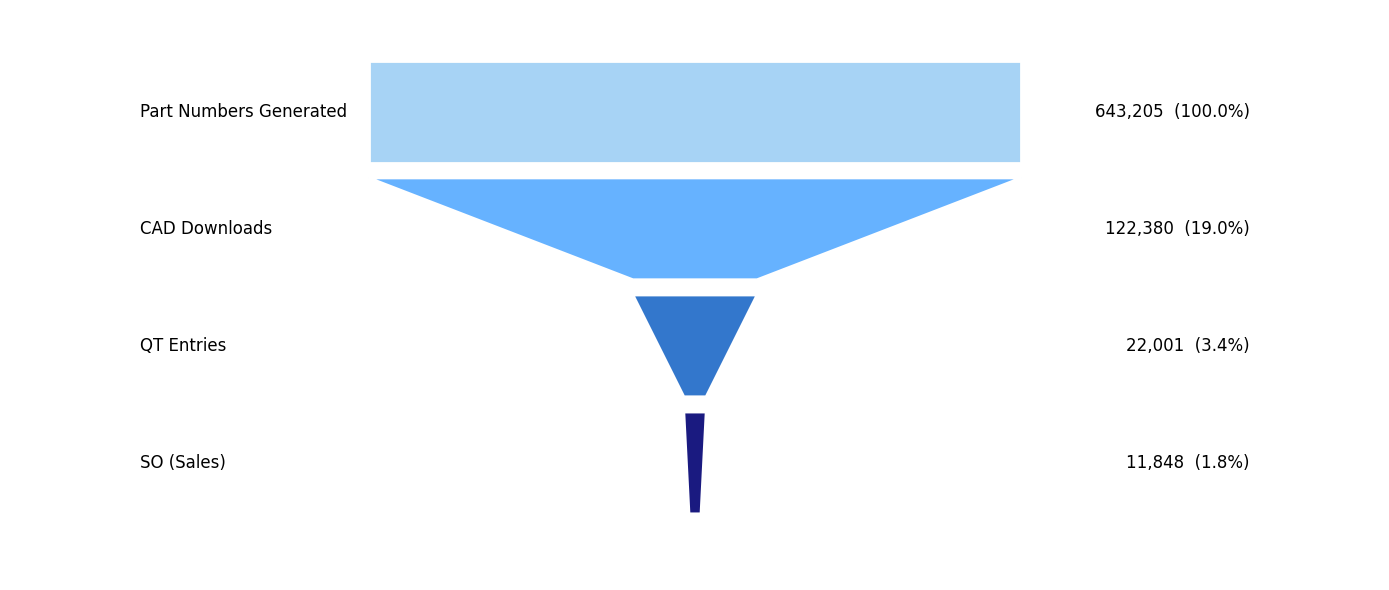

In [51]:
funnel_data = {
    "Part Numbers Generated": df_pngen_2425t["PN_QTY"].sum(),
    "CAD Downloads":          df_cad_2425t["CAD_QTY"].sum(),
    "QT Entries":             df_qt_2425t["QT_QTY"].sum(),
    "SO (Sales)":             df_so_2425t["SO_QTY"].sum(),
}

stages = sorted(funnel_data.items(), key=lambda x: x[1], reverse=True)
labels  = [s for s, _ in stages]
values  = [v for _, v in stages]
vmax    = max(values)

H = 1.0
gap = 0.15
Wmax = 14.0
left_pad  = 0.85 * Wmax
right_pad = 0.85 * Wmax
colors = ["#A7D3F5", "#66B2FF", "#3377CC", "#1A1A80"]

fig, ax = plt.subplots(figsize=(14,6))
y = 0.0
prev_w = Wmax

for i, (label, val) in enumerate(stages):
    w = Wmax * (val / vmax)
    top_y, bot_y = y, y + H

    poly = Polygon(
        [(-prev_w/2, top_y), (prev_w/2, top_y), (w/2, bot_y), (-w/2, bot_y)],
        closed=True, facecolor=colors[i % len(colors)],
        edgecolor='white', linewidth=2
    )
    ax.add_patch(poly)

    cy = (top_y + bot_y) / 2.0
    ax.text(
        -left_pad, cy, label,
        va="center", ha="left", fontsize=12, clip_on=False
    )
    ax.text(
        right_pad, cy, f"{val:,}  ({val/vmax:.1%})",
        va="center", ha="right", fontsize=12, clip_on=False
    )

    y = bot_y + gap
    prev_w = w

ax.set_xlim(-Wmax*1.05, Wmax*1.05)
ax.set_ylim(-0.5, y + 0.5)
ax.axis("off")
ax.invert_yaxis()
plt.tight_layout()
plt.show()



**Por Unique Customers**

In [52]:
df_so_2425t2 = df_so_2425t.sort_values(by="UNIQUE_CUSTOMERS", ascending=False).reset_index(drop=True)
df_qt_2425t2 = df_qt_2425t.sort_values(by="UNIQUE_CUSTOMERS", ascending=False).reset_index(drop=True)
df_pngen_2425t2 = df_pngen_2425t.sort_values(by="UNIQUE_CUSTOMERS", ascending=False).reset_index(drop=True)
df_cad_2425t2 = df_cad_2425t.sort_values(by="UNIQUE_CUSTOMERS", ascending=False).reset_index(drop=True)

In [53]:
df_so_2425t2.head(10)

,SERIES_CD,SO_QTY,UNIQUE_CUSTOMERS
0,110302657140,509,16
1,110302194710,807,13
2,110302657320,529,13
3,110300567730,338,12
4,110302660730,244,12
5,110302660820,421,11
6,110300578660,243,11
7,110300558270,644,11
8,110300567120,87,11
9,110300561160,330,10


In [54]:
df_qt_2425t2.head(10)

,SERIES_CD,QT_QTY,UNIQUE_CUSTOMERS
0,110302194710,1300,13
1,110300571230,772,12
2,110302657320,2122,11
3,110300567730,693,11
4,110300578660,560,11
5,110300567550,566,11
6,110300580240,271,11
7,110302660730,682,10
8,110302657140,782,10
9,110302664050,503,10


In [55]:
df_pngen_2425t2.head(10)

,SERIES_CD,PN_QTY,UNIQUE_CUSTOMERS
0,110300000000,145502,6404
1,221000000000,54297,5055
2,110302000000,61323,4550
3,110303000000,70898,4397
4,221006000000,37612,4320
5,221001000000,35856,4022
6,221005000000,30902,3660
7,110301000000,36181,2836
8,110100000000,62453,2568
9,110200000000,26681,1740


In [56]:
df_cad_2425t2.head(10)

,SERIES_CD,CAD_QTY,UNIQUE_CUSTOMERS
0,110300027060,994,344
1,221006300510,775,276
2,110302586530,750,240
3,110300147910,732,233
4,221000461736,524,232
5,110300258330,588,221
6,221000058413,460,221
7,221000091803,401,218
8,110302666420,786,215
9,221006298493,586,206


#### **Funnel por variabilidad en Customer Codes de PN Gen, CAD Download, Quotations y Sales Orders.**

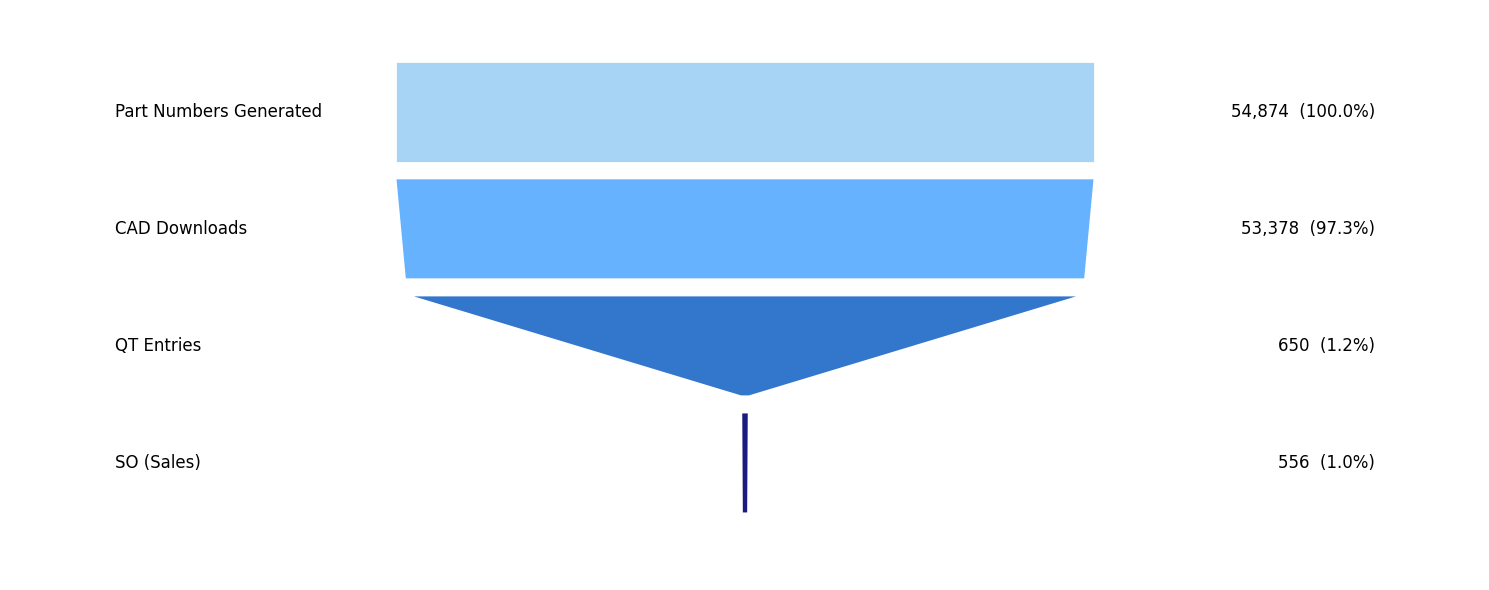

In [57]:
funnel_dfs = {
    "Part Numbers Generated": (df_pngen_2425t2, "UNIQUE_CUSTOMERS"),
    "CAD Downloads":          (df_cad_2425t2,  "UNIQUE_CUSTOMERS"),
    "QT Entries":             (df_qt_2425t2,   "UNIQUE_CUSTOMERS"),
    "SO (Sales)":             (df_so_2425t2,   "UNIQUE_CUSTOMERS"),
}

funnel_data = {name: df[col].sum() for name, (df, col) in funnel_dfs.items()}
stages = sorted(funnel_data.items(), key=lambda x: x[1], reverse=True)
labels  = [s for s, _ in stages]
values  = [v for _, v in stages]
vmax    = max(values) if values else 1

H = 1.0
gap = 0.15
Wmax = 14.0
left_pad  = 0.90 * Wmax
right_pad = 0.90 * Wmax
colors = ["#A7D3F5", "#66B2FF", "#3377CC", "#1A1A80"]

fig, ax = plt.subplots(figsize=(15,6))
y = 0.0
prev_w = Wmax

for i, (label, val) in enumerate(stages):
    w = Wmax * (val / vmax)
    top_y, bot_y = y, y + H
    poly = Polygon(
        [(-prev_w/2, top_y), (prev_w/2, top_y), (w/2, bot_y), (-w/2, bot_y)],
        closed=True, facecolor=colors[i % len(colors)],
        edgecolor='white', linewidth=2
    )
    ax.add_patch(poly)
    cy = (top_y + bot_y) / 2.0
    ax.text(-left_pad,  cy, label, va="center", ha="left",  fontsize=12, clip_on=False)
    ax.text( right_pad, cy, f"{val:,}  ({val/vmax:.1%})",
             va="center", ha="right", fontsize=12, clip_on=False)
    y = bot_y + gap
    prev_w = w

ax.set_xlim(-Wmax*1.05, Wmax*1.05)
ax.set_ylim(-0.5, y + 0.5)
ax.axis("off")
ax.invert_yaxis()
plt.tight_layout()
plt.show()


#### **Bar Plots: Visualizaciones estratégicas.**

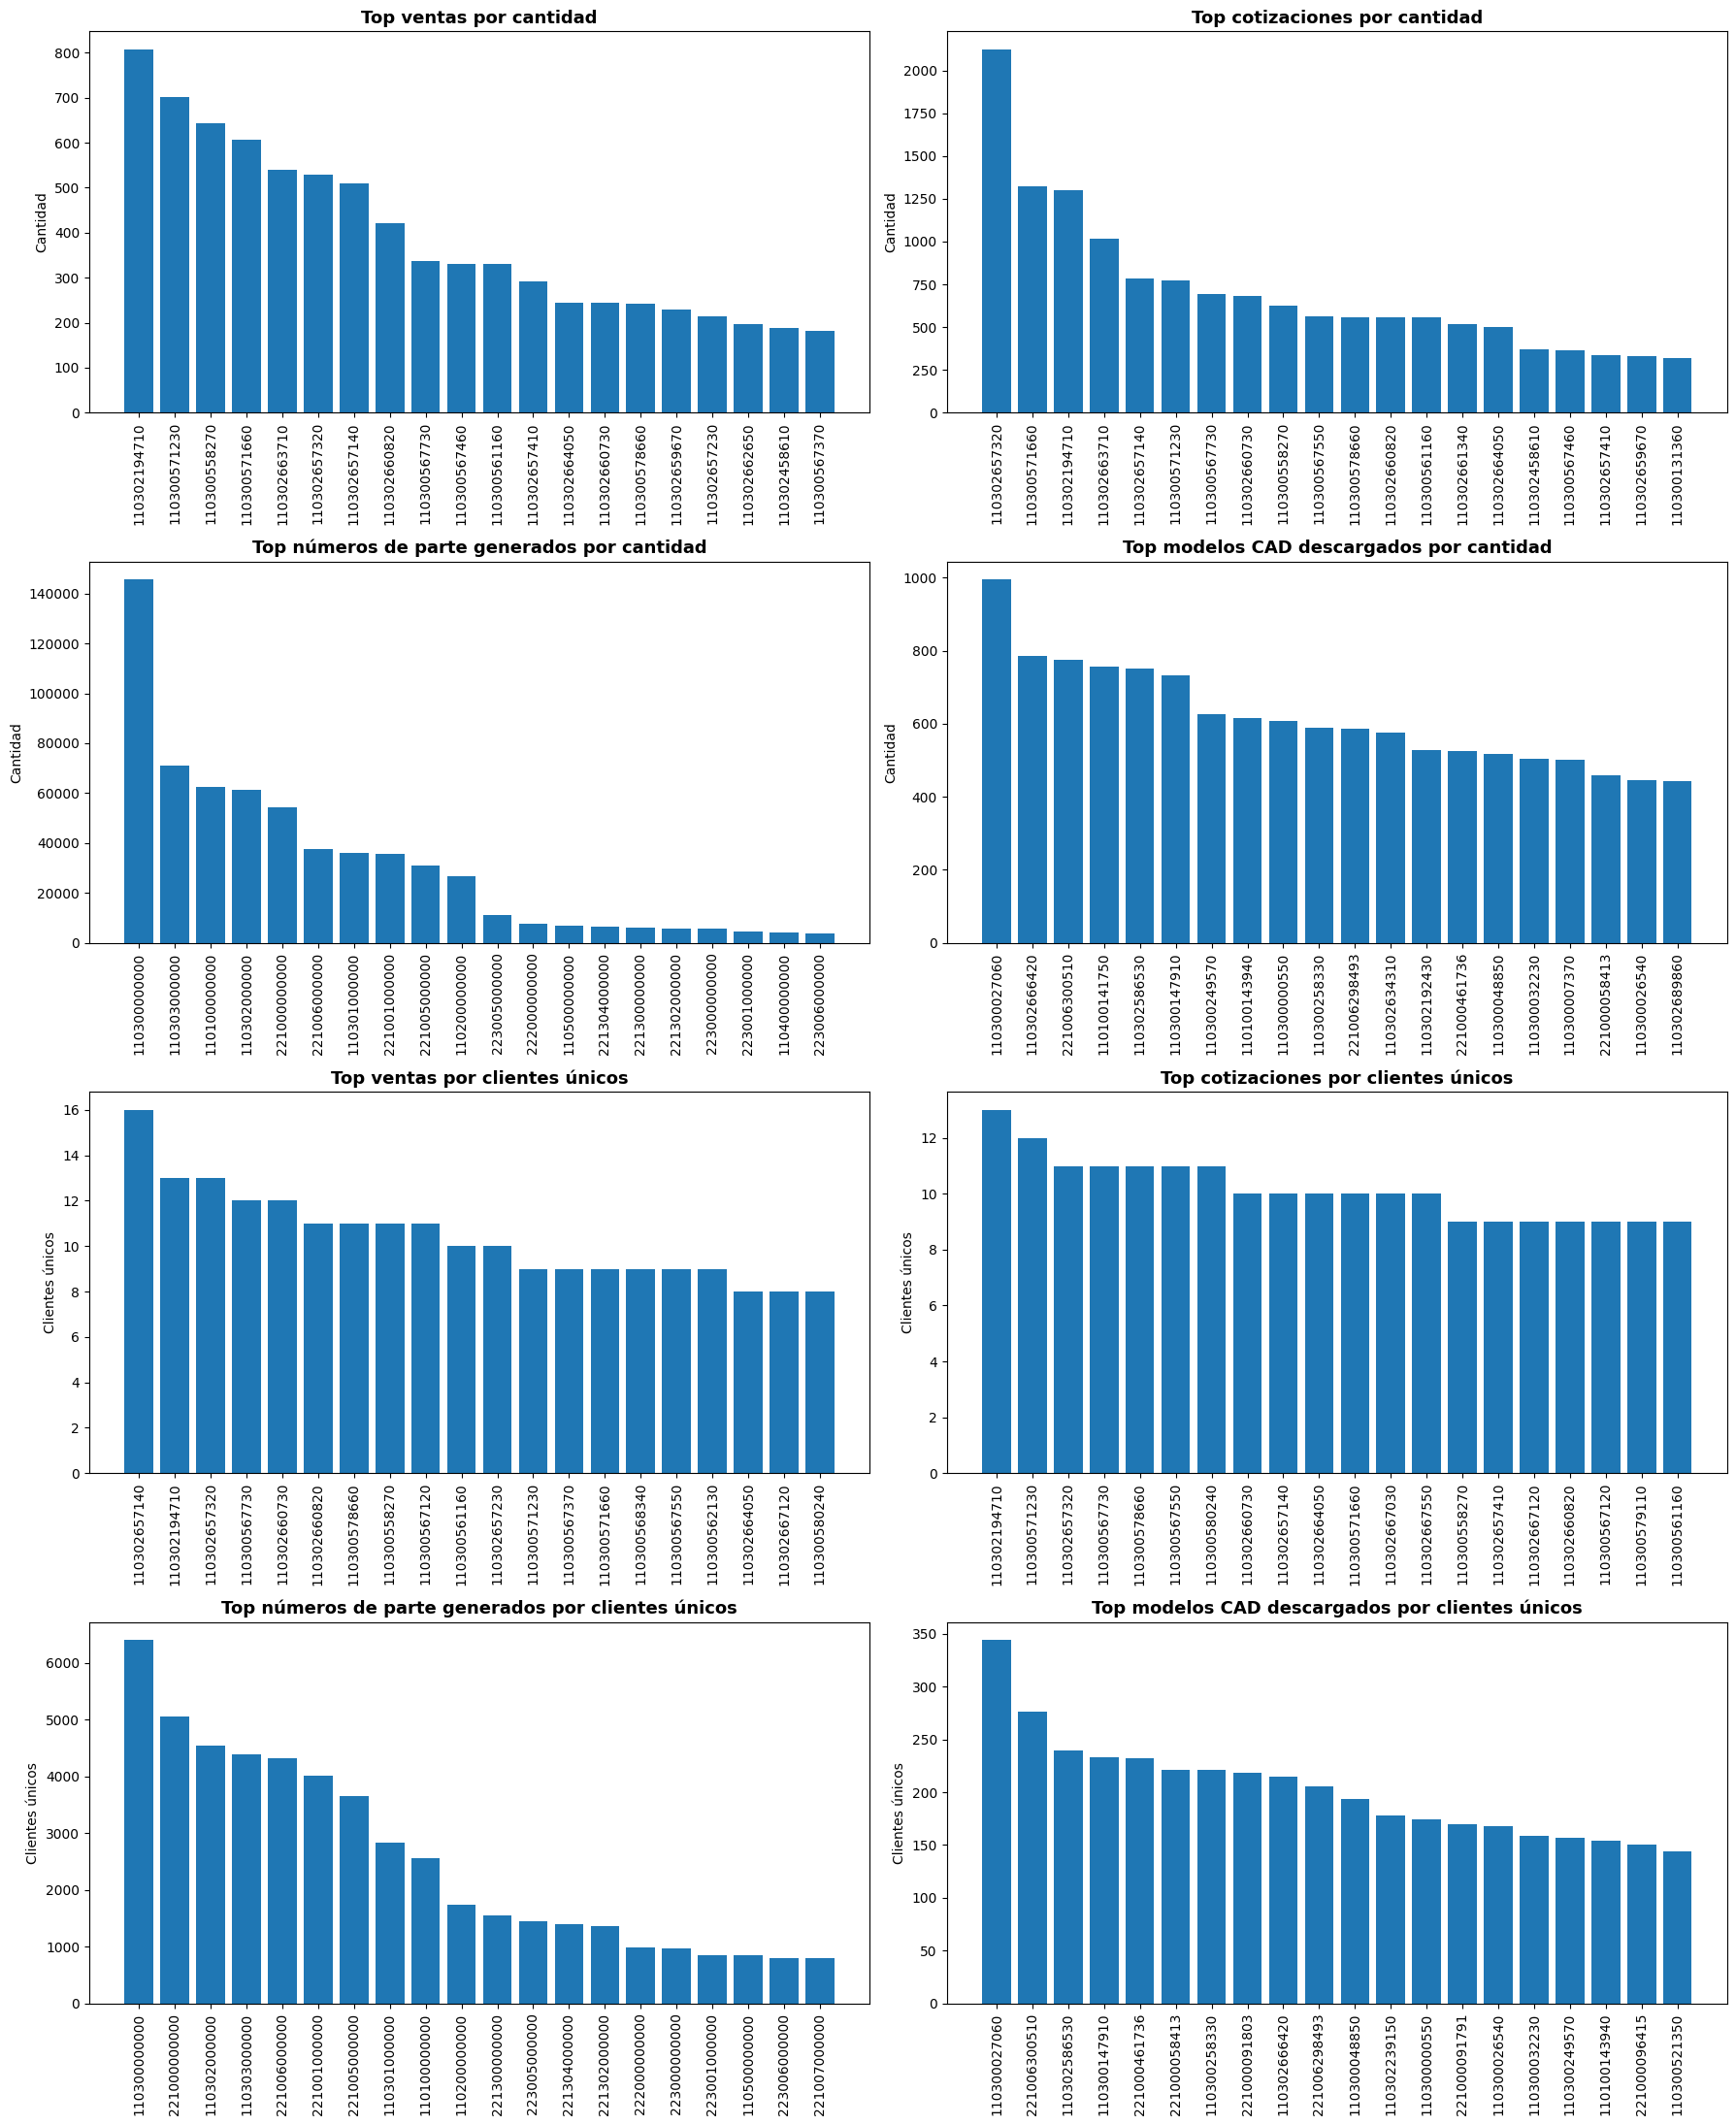

In [58]:
titles_and_specs = [
    ("Top ventas por cantidad",                            df_so_2425t,   "SO_QTY",            "Cantidad"),
    ("Top cotizaciones por cantidad",                      df_qt_2425t,   "QT_QTY",            "Cantidad"),
    ("Top números de parte generados por cantidad",        df_pngen_2425t,"PN_QTY",            "Cantidad"),
    ("Top modelos CAD descargados por cantidad",           df_cad_2425t,  "CAD_QTY",           "Cantidad"),
    ("Top ventas por clientes únicos",                     df_so_2425t2,   "UNIQUE_CUSTOMERS",  "Clientes únicos"),
    ("Top cotizaciones por clientes únicos",               df_qt_2425t2,   "UNIQUE_CUSTOMERS",  "Clientes únicos"),
    ("Top números de parte generados por clientes únicos", df_pngen_2425t2,"UNIQUE_CUSTOMERS",  "Clientes únicos"),
    ("Top modelos CAD descargados por clientes únicos",    df_cad_2425t2,  "UNIQUE_CUSTOMERS",  "Clientes únicos"),
]

fig, axes = plt.subplots(4, 2, figsize=(18, 22))
axes = axes.flatten()

for ax, (title, df, metric, ylabel) in zip(axes, titles_and_specs):
    top = df.sort_values(by=metric, ascending=False).head(20)
    ax.bar(top["SERIES_CD"].astype(str), top[metric])
    ax.set_title(title, fontsize=13, weight="bold")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()



#### **Data frames agrupados por customer codes asociados a cada Series Codes.**

In [59]:
gp_df_qt_2425 = (
    df_qt_2425.groupby("SERIES_CD")["CUSTOMER_CODE"]
    .apply(lambda x: list(set(x)))
    .reset_index()
    .assign(count=lambda x: x["CUSTOMER_CODE"].str.len())
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)


In [60]:
gp_df_qt_2425 = gp_df_qt_2425.drop(df.index[0])

In [61]:
gp_df_so_2425 = (
    df_so_2425.groupby("SERIES_CD")["CUSTOMER_CODE"]
    .apply(lambda x: list(set(x)))
    .reset_index()
    .assign(count=lambda x: x["CUSTOMER_CODE"].str.len())
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)


In [62]:
gp_cad_2425 = (
    df_cad_2425.groupby("SERIES_CODE")["CUSTOMER_CODE"]
    .apply(lambda x: list(set(x)))
    .reset_index()
    .assign(count=lambda x: x["CUSTOMER_CODE"].str.len())
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)


In [63]:
gp_cad_2425.head(10)

,SERIES_CODE,CUSTOMER_CODE,count
0,110300027060,"[VA0682, VC8014, ZA2883, ZA4356, VC1628, VA039...",345
1,221006300510,"[ZA6443, VB9853, VA3440, ZA1438, ZA6684, VC514...",277
2,110302586530,"[VA1706, VA0465, ZA5432, ZA2899, VA0682, VC417...",241
3,110300147910,"[VA3440, VC3932, VA9299, VA0154, VB3211, 37591...",233
4,221000461736,"[VD0610, VB8045, VC8185, VC6208, VA7360, VA953...",232
5,110300258330,"[VB2191, VA1706, ZA0358, ZA8002, ZA8185, ZA654...",222
6,221000058413,"[VA0651, ZA3617, ZA0358, ZA8782, VC7306, VA015...",222
7,221000091803,"[VA0651, VB2191, VA0465, VC9904, VA1284, VB905...",218
8,110302666420,"[VB2191, VA6306, ZA8670, VA0154, VA1204, 37591...",216
9,221006298493,"[VB2191, VC3293, ZA4802, VA6306, VD0610, VA486...",207


In [64]:
gp_pngen_2425 = (
    df_pngen_2425.groupby("SERIES_CODE")["CUSTOMER_CODE"]
    .apply(lambda x: list(set(x)))
    .reset_index()
    .assign(count=lambda x: x["CUSTOMER_CODE"].str.len())
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)


In [65]:
gp_pngen_2425.head(10)

,SERIES_CODE,CUSTOMER_CODE,count
0,110300000000,"[VC1843, VB4386, VB5473, VA9486, ZA9152, VA039...",6404
1,221000000000,"[VB6112, VB5473, VC1945, ZA4662, VA0392, VA420...",5055
2,110302000000,"[VB8045, VC2715, VC6016, VC7082, VC7169, VB328...",4550
3,110303000000,"[VC3132, VB8045, VC2715, VC6016, ZA1141, VC708...",4397
4,221006000000,"[VB8045, VC2715, VC6016, VC8267, ZA6684, VC716...",4320
5,221001000000,"[VB8045, VC6016, VC7082, VC7169, VC7179, ZA736...",4022
6,221005000000,"[VC2715, VC7082, VC6016, VC7169, VC0176, VC503...",3660
7,110301000000,"[VB8045, VC2715, VC6016, ZA9731, VC0176, VB328...",2836
8,110100000000,"[VC5905, VC2715, VC7169, VC1843, VC9339, VB328...",2568
9,110200000000,"[ZA1186, VB9786, VC8442, VC1123, 376870, VA039...",1740


## Funnel DLM Offering

Puede suceder que nuestro interés se enfoque ahora no solo en observar el comportamiento general de los clientes dentro de la categoría *Locating Pins*,  
sino también en aplicar un filtro que responda a la pregunta:  
**¿Cómo se comporta el funnel considerando únicamente los productos disponibles dentro del portafolio DLM?**

Para lograrlo, se trabaja con un **listado de series codes disponibles en DLM**, el cual se carga en un nuevo *data frame* que servirá como base para filtrar las etapas previas del funnel.  
De esta manera, se puede analizar el proceso comercial exclusivamente sobre los productos **ofrecidos por DLM**, permitiendo evaluar su desempeño individual frente al universo completo de *Locating Pins* y detectar oportunidades de expansión o mejora en la oferta actual.



In [66]:
dlm_series_offering = pd.read_excel("/content/dlm_series_offering.xlsx")

In [67]:
dlm_series_offering = dlm_series_offering.drop_duplicates().reset_index(drop=True)

Usamos los data frames que trabajamos al inicio para hacer un filtro en el cual solo se queden aquellas filas que cuyo valor en 'Series Code' empate con alguno de la lista en 'dlm_series_offering'

In [68]:
dlm_qt_2425t = df_qt_2425t[df_qt_2425t["SERIES_CD"].isin(dlm_series_offering["Series Code"])].copy()

In [69]:
dlm_qt_2425t.head(10)

,SERIES_CD,QT_QTY,UNIQUE_CUSTOMERS
0,110302657320,2122,11
2,110302194710,1300,13
4,110302657140,782,10
6,110300567730,693,11
7,110302660730,682,10
8,110300558270,628,9
9,110300567550,566,11
11,110302660820,559,9
12,110300561160,556,9
13,110302661340,520,3


In [70]:
dlm_so_2425t = df_so_2425t[df_so_2425t["SERIES_CD"].isin(dlm_series_offering["Series Code"])].copy()

In [71]:
dlm_so_2425t.head(10)

,SERIES_CD,SO_QTY,UNIQUE_CUSTOMERS
0,110302194710,807,13
2,110300558270,644,11
5,110302657320,529,13
6,110302657140,509,16
7,110302660820,421,11
8,110300567730,338,12
10,110300561160,330,10
11,110302657410,291,6
13,110302660730,244,12
15,110302659670,230,3


In [72]:
df_cad_2425t["SERIES_CD"] = (
    df_cad_2425t["SERIES_CD"].astype(str).str.strip().str.upper()
)
dlm_series_offering["Series Code"] = (
    dlm_series_offering["Series Code"].astype(str).str.strip().str.upper()
)

dlm_cad_2425t = df_cad_2425t[
    df_cad_2425t["SERIES_CD"].isin(dlm_series_offering["Series Code"])
].copy()


In [73]:
dlm_cad_2425t.head(10)

,SERIES_CD,CAD_QTY,UNIQUE_CUSTOMERS
29,110300567730,352,30
31,110300557930,340,88
32,110300557320,332,111
86,110300565270,183,55
121,110300567550,146,47
131,110302657140,142,46
133,110302657320,142,39
174,110302194710,125,48
194,110300558270,116,35
231,110300561160,102,38


In [75]:
df_pngen_2425t["SERIES_CD"] = (
    df_pngen_2425t["SERIES_CD"].astype(str).str.strip().str.upper()
)
dlm_series_offering["Series Code"] = (
    dlm_series_offering["Series Code"].astype(str).str.strip().str.upper()
)

dlm_pngen_2425t = df_pngen_2425t[
    df_pngen_2425t["SERIES_CD"].isin(dlm_series_offering["Series Code"])
].copy()

In [76]:
df_pngen_2425t.head(10)

,SERIES_CD,PN_QTY,UNIQUE_CUSTOMERS
0,110300000000,145502,6404
1,110303000000,70898,4397
2,110100000000,62453,2568
3,110302000000,61323,4550
4,221000000000,54297,5055
5,221006000000,37612,4320
6,110301000000,36181,2836
7,221001000000,35856,4022
8,221005000000,30902,3660
9,110200000000,26681,1740


Hacemos lo mismo para poder generar los Data Frames de los números de parte generados, CAD descargdos, cotizados y vendidos pero usando la cantidad de Clientes únicos en cada etapa del funnel.

In [77]:
gp_dlm_qt_2425t = dlm_qt_2425t.sort_values(
    by="UNIQUE_CUSTOMERS", ascending=False
).reset_index(drop=True)

In [78]:
gp_dlm_qt_2425t.head(10)

,SERIES_CD,QT_QTY,UNIQUE_CUSTOMERS
0,110302194710,1300,13
1,110302657320,2122,11
2,110300567730,693,11
3,110300567550,566,11
4,110302657140,782,10
5,110302660730,682,10
6,110300558270,628,9
7,110302660820,559,9
8,110300561160,556,9
9,110302657410,335,9


In [79]:
gp_dlm_so_2425t = dlm_so_2425t.sort_values(
    by="UNIQUE_CUSTOMERS", ascending=False
).reset_index(drop=True)

In [80]:
gp_dlm_so_2425t.head(10)

,SERIES_CD,SO_QTY,UNIQUE_CUSTOMERS
0,110302657140,509,16
1,110302194710,807,13
2,110302657320,529,13
3,110300567730,338,12
4,110302660730,244,12
5,110300558270,644,11
6,110302660820,421,11
7,110300567120,87,11
8,110302657230,215,10
9,110300561160,330,10


In [81]:
gp_dlm_cad_2425t = dlm_cad_2425t.sort_values(
    by="UNIQUE_CUSTOMERS", ascending=False
).reset_index(drop=True)

In [82]:
gp_dlm_cad_2425t.head(10)

,SERIES_CD,CAD_QTY,UNIQUE_CUSTOMERS
0,110300557320,332,111
1,110300557930,340,88
2,110300565270,183,55
3,110302194710,125,48
4,110300567550,146,47
5,110302657140,142,46
6,110302657320,142,39
7,110300561160,102,38
8,110300558270,116,35
9,110300567730,352,30


In [83]:
gp_dlm_pngen_2425t = df_pngen_2425t.sort_values(
    by="UNIQUE_CUSTOMERS", ascending=False
).reset_index(drop=True)

In [84]:
gp_dlm_pngen_2425t.head(10)

,SERIES_CD,PN_QTY,UNIQUE_CUSTOMERS
0,110300000000,145502,6404
1,221000000000,54297,5055
2,110302000000,61323,4550
3,110303000000,70898,4397
4,221006000000,37612,4320
5,221001000000,35856,4022
6,221005000000,30902,3660
7,110301000000,36181,2836
8,110100000000,62453,2568
9,110200000000,26681,1740


Generamos la visualización del funnel solo para los Series Codes que se ofrecen en DLM por cantidades totales

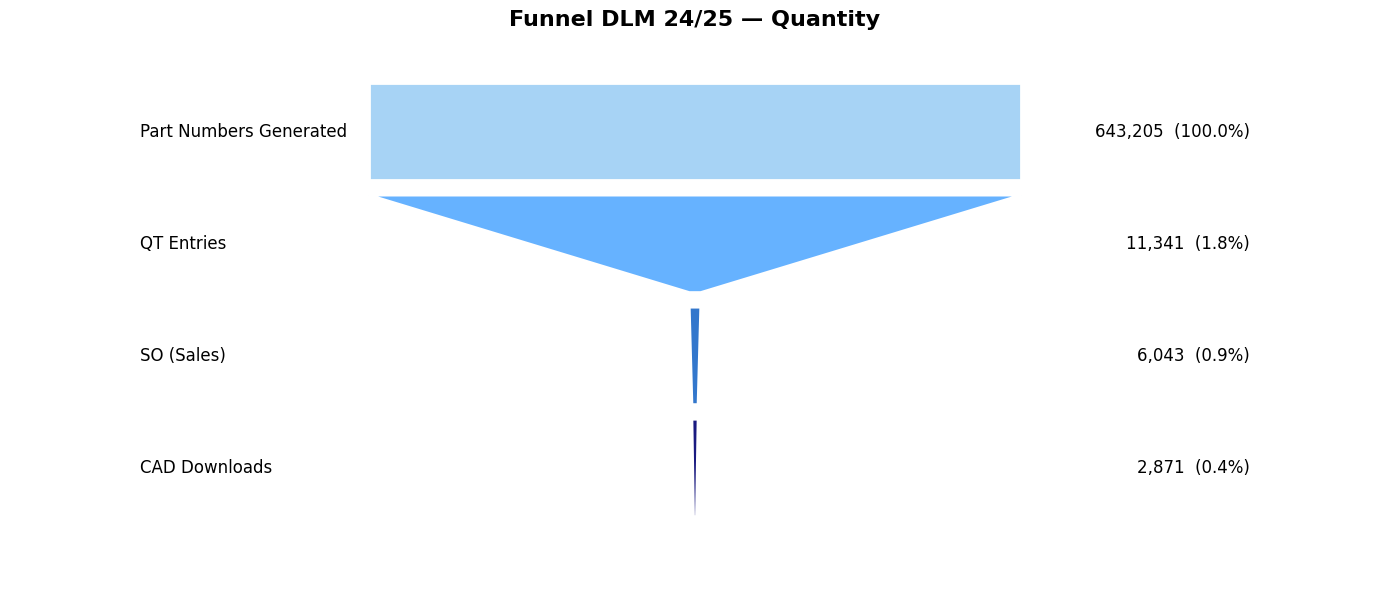

In [85]:
def total(df, col):
    return pd.to_numeric(df[col], errors="coerce").fillna(0).sum()

funnel_data = {
    "Part Numbers Generated": total(df_pngen_2425t, "PN_QTY"),
    "CAD Downloads":          total(dlm_cad_2425t,  "CAD_QTY"),
    "QT Entries":             total(dlm_qt_2425t,   "QT_QTY"),
    "SO (Sales)":             total(dlm_so_2425t,   "SO_QTY"),
}

stages = sorted(funnel_data.items(), key=lambda x: x[1], reverse=True)
labels  = [s for s, _ in stages]
values  = [v for _, v in stages]

vmax = max(values) if len(values) and max(values) > 0 else 1

H = 1.0
gap = 0.15
Wmax = 14.0
left_pad  = 0.85 * Wmax
right_pad = 0.85 * Wmax
colors = ["#A7D3F5", "#66B2FF", "#3377CC", "#1A1A80"]

fig, ax = plt.subplots(figsize=(14, 6))
plt.title("Funnel DLM 24/25 — Quantity", fontsize=16, fontweight="bold")
y = 0.0
prev_w = Wmax

for i, (label, val) in enumerate(stages):
    w = Wmax * (val / vmax)
    top_y, bot_y = y, y + H

    poly = Polygon(
        [(-prev_w/2, top_y), (prev_w/2, top_y), (w/2, bot_y), (-w/2, bot_y)],
        closed=True, facecolor=colors[i % len(colors)],
        edgecolor='white', linewidth=2
    )
    ax.add_patch(poly)

    cy = (top_y + bot_y) / 2.0
    ax.text(-left_pad, cy, label, va="center", ha="left", fontsize=12, clip_on=False)
    ax.text(right_pad, cy, f"{int(val):,}  ({val/vmax:.1%})",
            va="center", ha="right", fontsize=12, clip_on=False)

    y = bot_y + gap
    prev_w = w

ax.set_xlim(-Wmax*1.05, Wmax*1.05)
ax.set_ylim(-0.5, y + 0.5)
ax.axis("off")
ax.invert_yaxis()
plt.tight_layout()
plt.show()


Generamos la visualización del funnel solo para los Series Codes que se ofrecen en DLM por clientes únicos.

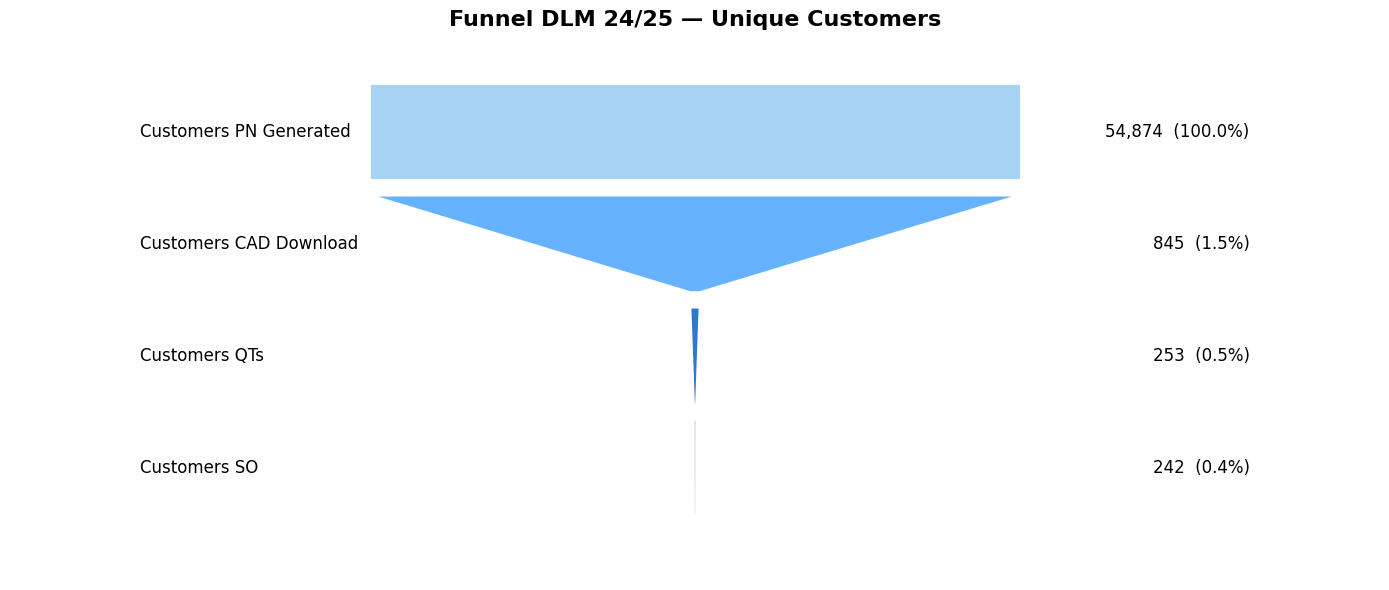

In [86]:
def total_uc(df):
    return pd.to_numeric(df["UNIQUE_CUSTOMERS"], errors="coerce").fillna(0).sum()

funnel_data = {
    "Customers PN Generated": total_uc(gp_dlm_pngen_2425t),
    "Customers CAD Download":          total_uc(gp_dlm_cad_2425t),
    "Customers QTs":             total_uc(gp_dlm_qt_2425t),
    "Customers SO":             total_uc(gp_dlm_so_2425t),
}

stages = sorted(funnel_data.items(), key=lambda x: x[1], reverse=True)
labels  = [s for s, _ in stages]
values  = [v for _, v in stages]
vmax    = max(values) if len(values) and max(values) > 0 else 1

H = 1.0
gap = 0.15
Wmax = 14.0
left_pad  = 0.85 * Wmax
right_pad = 0.85 * Wmax
colors = ["#A7D3F5", "#66B2FF", "#3377CC", "#1A1A80"]

fig, ax = plt.subplots(figsize=(14, 6))
plt.title("Funnel DLM 24/25 — Unique Customers", fontsize=16, fontweight="bold")
y = 0.0
prev_w = Wmax

for i, (label, val) in enumerate(stages):
    w = Wmax * (val / vmax)
    top_y, bot_y = y, y + H

    poly = Polygon(
        [(-prev_w/2, top_y), (prev_w/2, top_y), (w/2, bot_y), (-w/2, bot_y)],
        closed=True, facecolor=colors[i % len(colors)],
        edgecolor='white', linewidth=2
    )
    ax.add_patch(poly)

    cy = (top_y + bot_y) / 2.0
    ax.text(-left_pad, cy, label, va="center", ha="left", fontsize=12, clip_on=False)
    ax.text(right_pad, cy, f"{int(val):,}  ({val/vmax:.1%})",
            va="center", ha="right", fontsize=12, clip_on=False)

    y = bot_y + gap
    prev_w = w

ax.set_xlim(-Wmax*1.05, Wmax*1.05)
ax.set_ylim(-0.5, y + 0.5)
ax.axis("off")
ax.invert_yaxis()
plt.tight_layout()
plt.show()


# **Conclusiones de Negocio**

El análisis del *path to purchase* para la categoría **Locating Pins** permitió identificar patrones de comportamiento del cliente y puntos clave dentro del proceso comercial que impactan directamente en las **ventas y conversión**.

1. **Alta generación de interés técnico:**  
   La cantidad de números de parte generados y descargas CAD indica un fuerte nivel de exploración y validación técnica por parte de los ingenieros, lo que confirma el posicionamiento de MISUMI como referente en la etapa de diseño.

2. **Brecha entre interés y conversión:**  
   Se observa una disminución significativa entre las etapas de cotización y venta. Esto sugiere oportunidades de mejora en **seguimiento comercial, disponibilidad de producto y competitividad de precios**, especialmente en los códigos más cotizados.

3. **Identificación de productos de alto impacto:**  
   Los *part numbers* con mayor frecuencia en descargas y cotizaciones pueden priorizarse dentro de campañas de marketing técnico o gestión de inventario, al representar una **alta probabilidad de conversión**.

4. **Análisis de oferta DLM:**  
   Al filtrar los datos por series disponibles en DLM, se evidencia que existe una porción relevante del interés que aún no se convierte en ventas, lo que abre oportunidades de **ampliar el surtido local** o **ajustar el portafolio DLM** a la demanda real del cliente mexicano.

5. **Valor estratégico del modelo analítico:**  
   El desarrollo del funnel dinámico y el enriquecimiento de datos mediante *web scraping* permiten transformar información dispersa en **insights accionables**, fortaleciendo la toma de decisiones basada en datos y la priorización de esfuerzos comerciales.

En conjunto, el estudio demuestra que el uso de técnicas de *Data Science* aplicadas a datos de interacción y ventas puede **mejorar la gestión del embudo comercial**, optimizar la oferta disponible y orientar la estrategia comercial de MISUMI México hacia una **mayor eficiencia en la conversión y retención de clientes**.

